In [2]:
# 0. Colab setup ---------------------------------------------------------------
!pip install -q torch torchvision torchaudio onnx onnxruntime scikit-learn pandas numpy matplotlib

import io, json, numpy as np, pandas as pd
from google.colab import files
import torch, torch.nn as nn, torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.2 MB/s eta 0:00:00


In [10]:
# 1. Upload dataset ------------------------------------------------------------
import os
os.chdir('/content/drive/MyDrive/sign-language-estimator')
df = pd.read_csv("sign_dataset.csv")
df.head()

,label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125
0,hello,0,0,0,0.413271,-0.214589,-0.057533,0.667666,-0.559519,-0.055932,...,0.001932,-0.007654,-1.195885,-0.093611,-0.001429,-0.876740,-0.029100,0.054069,-0.720876,0.058447
1,hello,0,0,0,0.394748,-0.049623,-0.110125,0.698776,-0.541648,-0.115542,...,-0.002981,-0.004410,-1.191136,-0.106348,0.002595,-0.876187,-0.046919,0.055180,-0.721776,0.039380
2,hello,0,0,0,0.395022,-0.117504,-0.093542,0.662924,-0.553102,-0.097966,...,0.055968,0.008573,-1.256085,0.005156,-0.010206,-1.037742,0.062673,0.006174,-0.856370,0.136890
3,hello,0,0,0,0.444675,-0.151113,-0.062686,0.738286,-0.454848,-0.071861,...,-0.006894,-0.043814,-1.200112,-0.090526,-0.033752,-0.922330,-0.024875,0.019874,-0.755552,0.062163
4,hello,0,0,0,0.447198,-0.018268,-0.076895,0.779144,-0.433174,-0.063824,...,-0.082411,0.066253,-1.211671,-0.190475,0.076724,-0.854039,-0.114303,0.132575,-0.744232,-0.020031


In [11]:
# 2. Split features / labels ---------------------------------------------------
X = df.drop(columns=["label"]).values.astype("float32")
y_text = df["label"].values

le = LabelEncoder()
y = le.fit_transform(y_text)              # maps hello→0, love→1, etc.
num_classes = len(le.classes_)
print("Label mapping:", dict(zip(le.classes_, range(num_classes))))

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val   = torch.tensor(y_val, dtype=torch.long)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Label mapping: {'hello': 0, 'love': 1, 'nice': 2, 'thanks': 3}


In [12]:
# 3. Define model --------------------------------------------------------------
class GestureMLP(nn.Module):
    def __init__(self, in_dim=126, hidden=(128, 64), num_classes=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden[0]),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden[0], hidden[1]),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden[1], num_classes),
        )

    def forward(self, x):
        return self.net(x)

model = GestureMLP(in_dim=X.shape[1], num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
# 4. Training loop -------------------------------------------------------------
def run_epoch(split):
    model.train(split == "train")
    data_x = X_train if split == "train" else X_val
    data_y = y_train if split == "train" else y_val
    batch_size = 64
    losses, correct = [], 0

    for idx in range(0, len(data_x), batch_size):
        xb = data_x[idx : idx + batch_size].to(device)
        yb = data_y[idx : idx + batch_size].to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        if split == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        losses.append(loss.item())

    return np.mean(losses), correct / len(data_x)

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
epochs = 40

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch("train")
    val_loss, val_acc = run_epoch("val")

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"[{epoch:02d}] loss {train_loss:.4f}/{val_loss:.4f} "
          f"acc {train_acc:.3f}/{val_acc:.3f}")

[01] loss 1.2619/1.0836 acc 0.609/0.887
[02] loss 0.9957/0.7875 acc 0.903/0.938
[03] loss 0.7100/0.4955 acc 0.931/0.938
[04] loss 0.4430/0.2829 acc 0.938/0.950
[05] loss 0.2662/0.1694 acc 0.953/0.950
[06] loss 0.1700/0.1126 acc 0.950/0.963
[07] loss 0.1113/0.0773 acc 0.972/0.988
[08] loss 0.0809/0.0521 acc 0.981/0.988
[09] loss 0.0504/0.0343 acc 1.000/0.988
[10] loss 0.0311/0.0232 acc 1.000/0.988
[11] loss 0.0223/0.0162 acc 1.000/1.000
[12] loss 0.0175/0.0115 acc 1.000/1.000
[13] loss 0.0100/0.0089 acc 1.000/1.000
[14] loss 0.0086/0.0074 acc 1.000/1.000
[15] loss 0.0061/0.0063 acc 1.000/1.000
[16] loss 0.0057/0.0055 acc 1.000/1.000
[17] loss 0.0042/0.0047 acc 1.000/1.000
[18] loss 0.0041/0.0041 acc 1.000/1.000
[19] loss 0.0036/0.0035 acc 1.000/1.000
[20] loss 0.0034/0.0031 acc 1.000/1.000
[21] loss 0.0029/0.0029 acc 1.000/1.000
[22] loss 0.0032/0.0027 acc 1.000/1.000
[23] loss 0.0047/0.0025 acc 1.000/1.000
[24] loss 0.0029/0.0023 acc 1.000/1.000
[25] loss 0.0027/0.0022 acc 1.000/1.000


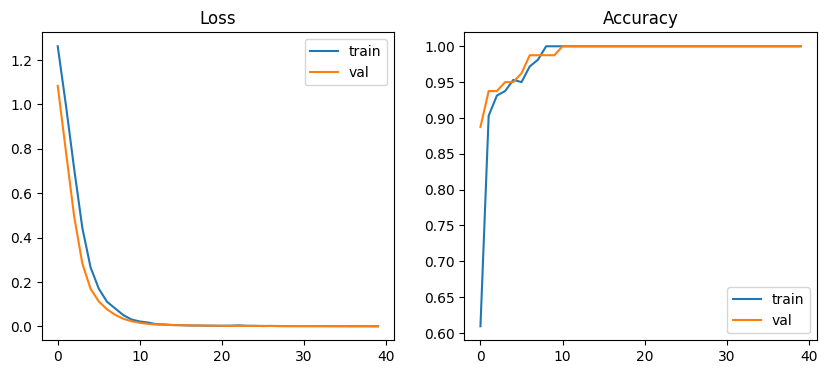

              precision    recall  f1-score   support

       hello       1.00      1.00      1.00        20
        love       1.00      1.00      1.00        20
        nice       1.00      1.00      1.00        20
      thanks       1.00      1.00      1.00        20

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

[[20  0  0  0]
 [ 0 20  0  0]
 [ 0  0 20  0]
 [ 0  0  0 20]]


In [14]:
# 5. Plot & confusion matrix ---------------------------------------------------
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history["train_loss"], label="train"); plt.plot(history["val_loss"], label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history["train_acc"], label="train"); plt.plot(history["val_acc"], label="val"); plt.title("Accuracy"); plt.legend()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
model.eval()
with torch.no_grad():
    preds = model(X_val.to(device)).argmax(dim=1).cpu().numpy()

print(classification_report(y_val.numpy(), preds, target_names=le.classes_))
print(confusion_matrix(y_val.numpy(), preds))

In [16]:
!pip install -q onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 2.4 MB/s eta 0:00:00


In [17]:
# 6. Export artifacts ----------------------------------------------------------
import pickle, onnx

torch.save(model.state_dict(), "gesture_mlp.pt")
with open("scaler.pkl", "wb") as f: pickle.dump(scaler, f)
with open("label_encoder.pkl", "wb") as f: pickle.dump(le, f)

dummy = torch.randn(1, X.shape[1], device=device)
torch.onnx.export(
    model, dummy, "gesture_mlp.onnx",
    input_names=["input"], output_names=["logits"],
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
    opset_version=17
)

files.download("gesture_mlp.pt")
files.download("gesture_mlp.onnx")
files.download("scaler.pkl")
files.download("label_encoder.pkl")

/tmp/ipython-input-3687940589.py:9: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1122 08:04:17.722000 655 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 17 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `GestureMLP([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `GestureMLP([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# C++에서 쓰기 쉽도록 추가로 추출
np.savez("gesture_weights",
         w1=model.net[0].weight.detach().cpu().numpy(),
         b1=model.net[0].bias.detach().cpu().numpy(),
         w2=model.net[3].weight.detach().cpu().numpy(),
         b2=model.net[3].bias.detach().cpu().numpy(),
         w3=model.net[6].weight.detach().cpu().numpy(),
         b3=model.net[6].bias.detach().cpu().numpy())

json.dump({"mean": scaler.mean_.tolist(), "scale": scaler.scale_.tolist()}, open("scaler.json","w"))
json.dump({"labels": le.classes_.tolist()}, open("labels.json","w"))

files.download("gesture_weights.npz")
files.download("scaler.json")
files.download("labels.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
def emit(name, arr):
    flat = ", ".join(f"{x:.8f}f" for x in arr.flatten())
    return f"static const float {name}[] = {{{flat}}};\n"

with torch.no_grad():
    header = (
        emit("W1", model.net[0].weight.cpu().numpy()) +
        emit("B1", model.net[0].bias.cpu().numpy())  +
        emit("W2", model.net[3].weight.cpu().numpy()) +
        emit("B2", model.net[3].bias.cpu().numpy())  +
        emit("W3", model.net[6].weight.cpu().numpy()) +
        emit("B3", model.net[6].bias.cpu().numpy())
    )

with open("gesture_weights.h", "w") as f:
    f.write(header)


files.download("gesture_weights.h")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>